# Inference with Autoencoder

In [59]:
# Load all related modules
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image

from torchvision import datasets
import torchvision.transforms as T

import res.viz_utils as vu

from res.plot_lib import plot_data, show_scatterplot, set_default

set_default()

In [60]:

DATA_DIR = "data"
MODEL_DIR = "models"
IS_DENOISING = True
NOISE_TYPE = "gaussian"

NUM_EPOCH = 30
BATCH_SIZE = 256
hidden_size = 128

mname = "ae" if not IS_DENOISING else f"dae_{NOISE_TYPE}"
model_path = os.path.join(MODEL_DIR, f"{mname}_mnist_z{hidden_size}_ep{NUM_EPOCH}.pth")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Load Dataset

In [61]:
# Load training and test data
img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=img_transform,
)

test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=img_transform,
)

# Create data loader
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

test_loader = DataLoader(
    test_data,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

[n, dx1, dx2] = train_data.data.size()

### Load model

In [62]:
# Defune model architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Tanh(),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y
    
criterion = nn.MSELoss()

In [63]:
print(f"Using {DEVICE} device: {model_path}")

# Define model
input_size = 28 * 28
model = Autoencoder(input_size, hidden_size).to(DEVICE)

model.load_state_dict(torch.load(model_path))
model.eval()

print(model)

Using cpu device: models/dae_gaussian_mnist_z128_ep30.pth
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Tanh()
  )
)


### Visualize Weights

img_np : 0.0 1.0


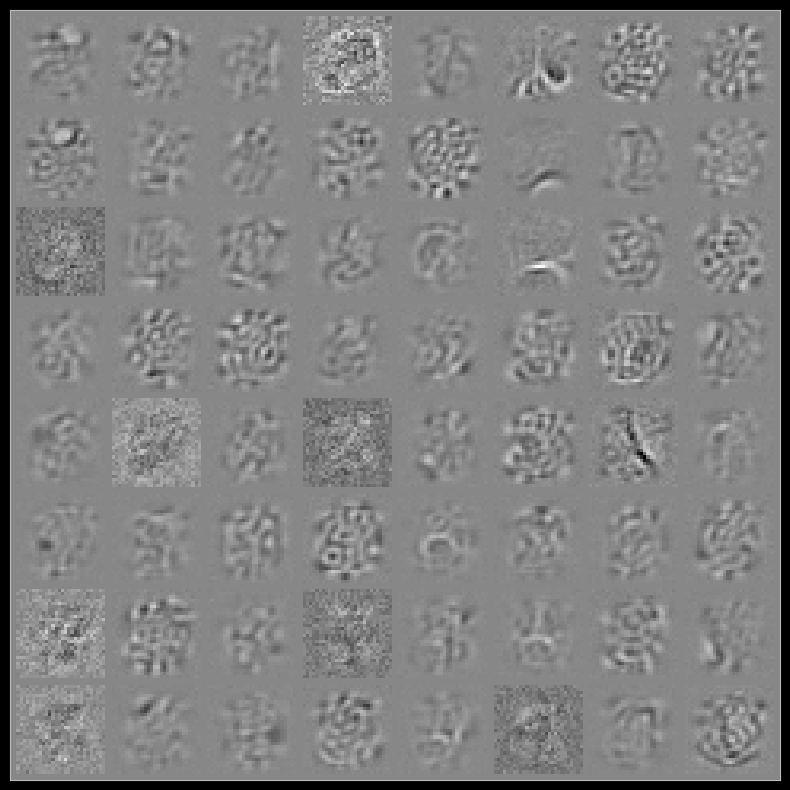

In [64]:
W = model.encoder[0].weight.view(-1, 1, dx1, dx2)

# Visualize training data
grid = vu.set_grid(W, num_cells=64)
vu.show(grid)


### Image Reconstruction

In [65]:
X, _ = next(iter(train_loader))
Xt, _ = next(iter(test_loader))

In [66]:
# Reconstruct images
with torch.no_grad():
    # Feedforward
    x = X.view(-1, input_size).to(DEVICE)
    xt = Xt.view(-1, input_size).to(DEVICE)

    x_rec = model(x)
    xt_rec = model(xt)

    X_rec = x_rec.view(-1, 1, dx1, dx2)
    Xt_rec = xt_rec.view(-1, 1, dx1, dx2)

    # Compute loss
    train_rec_loss = criterion(x_rec, x).item()
    test_rec_loss = criterion(xt_rec, xt).item()

    print(f"Train reconstruction loss: {train_rec_loss:.4f}")
    print(f"Test reconstruction loss: {test_rec_loss:.4f}")

Train reconstruction loss: 0.0191
Test reconstruction loss: 0.0190


img_np : 0.0 1.0


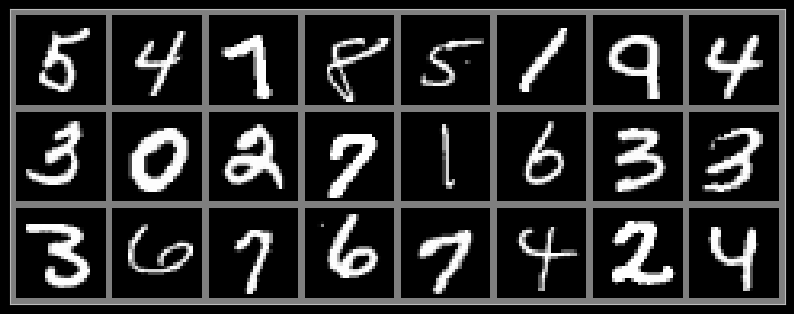

In [67]:
# Visualize training data
grid = vu.set_grid(X, num_cells=24)
vu.show(grid)

img_np : 0.0 1.0


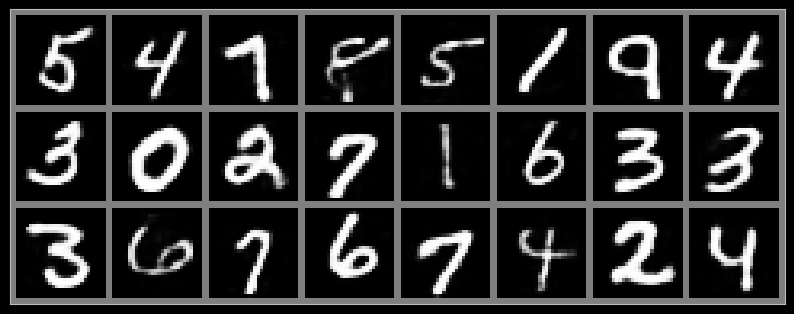

In [68]:
# Visualize training reconstruction
grid = vu.set_grid(X_rec, num_cells=24)
vu.show(grid)

img_np : 0.0 1.0


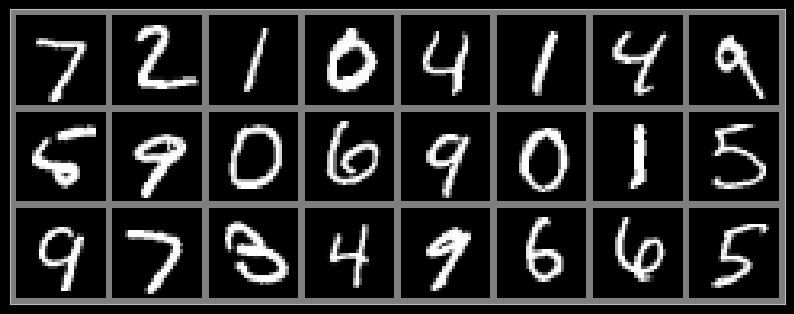

In [69]:
# Visualize test data
grid = vu.set_grid(Xt, num_cells=24)
vu.show(grid)

img_np : 0.0 1.0


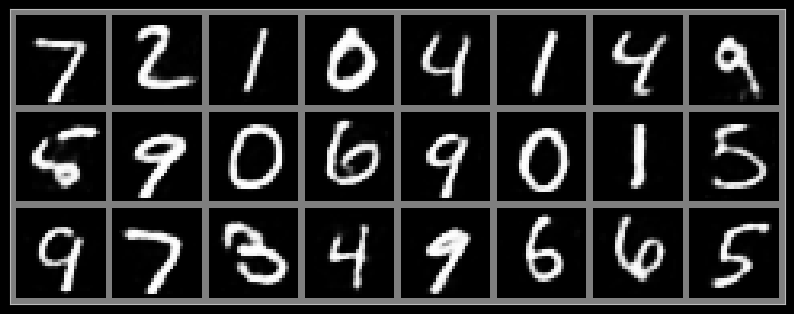

In [70]:
# Visualize test reconstruction
grid = vu.set_grid(Xt_rec, num_cells=24)
vu.show(grid)

### Image Morphing

In [71]:
def morph(model, xs, xt, n_steps=5):
    """
    Args:
        model (nn.Module): AE model
        xs (torch.Tensor): source image vector
        xt (torch.Tensor): target image vector
        n_steps (int): number 
    
    """
    # Visualize inputs
    X_input = torch.stack([xs, xt], dim=0)
    X2d = X_input.reshape((-1, dx1, dx2))
    grid = vu.set_grid(X2d, num_cells=2)
    vu.show(grid)
    
    zs = model.encoder(xs)
    zt = model.encoder(xt)
    
    # Linear interpolate on Z codes
    t_list = np.linspace(0, 1, n_steps).tolist()
    z_list = []
    for t in t_list:
        z_list.append(torch.lerp(zs, zt, t))

    Zm = torch.stack(z_list, dim=0)

    # Decode morphed images
    Xm = model.decoder(Zm)
    
    # Visualize the morphed images
    X2d = Xm.reshape((-1, dx1, dx2))
    grid = vu.set_grid(X2d, num_cells=len(z_list))
    vu.show(grid)

In [72]:
Xt[2].view(input_size).size()

torch.Size([784])

img_np : 0.0 1.0
img_np : 0.0 1.0


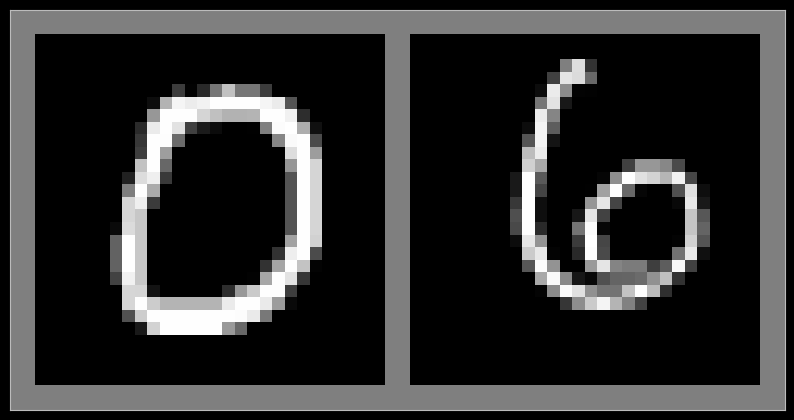

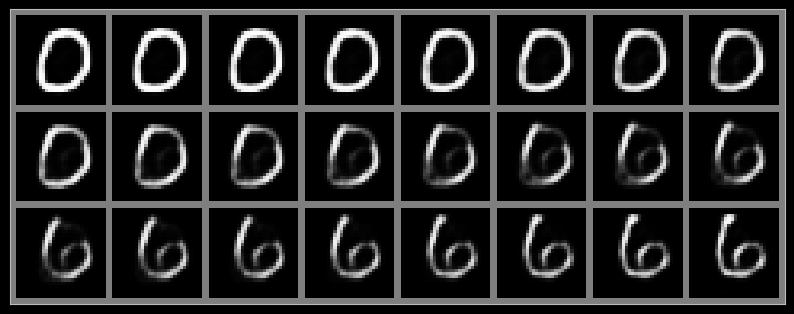

In [73]:
morph(model, Xt[10].view(input_size), Xt[100].view(input_size), n_steps=24)

### Latent Code Separation

1. Encode the input images into their corresponding latent codes
2. Reduce the dimensionality of the codes into 2-dim through manifold learning with tSNE
3. Visualize the 2-dim codes

In [74]:
from sklearn.manifold import TSNE

In [75]:
# Load models
model_ae = Autoencoder(input_size, hidden_size).to(DEVICE)
model_ae.load_state_dict(torch.load(os.path.join(MODEL_DIR, "ae_mnist_z128_ep30.pth")))
model_ae.eval()

model_dae = Autoencoder(input_size, hidden_size).to(DEVICE)
model_dae.load_state_dict(torch.load(os.path.join(MODEL_DIR, "dae_gaussian_mnist_z128_ep30.pth")))
model_dae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [76]:
# Get all test codes
Zt_ae = []
Zt_dae = []
Yt = []
for batch_idx, (Xt, yt) in enumerate(test_loader):
    with torch.no_grad():
        zt_ae = model_ae.encoder(Xt.view(-1, input_size).to(DEVICE))
        zt_dae = model_dae.encoder(Xt.view(-1, input_size).to(DEVICE))
    
    Zt_ae.append(zt_ae)
    Zt_dae.append(zt_dae)
    Yt.append(yt)

    if batch_idx == 4:
        break
Zt_ae = torch.concatenate(Zt_ae, axis=0)
Zt_dae = torch.concatenate(Zt_dae, axis=0)
Yt = torch.concatenate(Yt, axis=0)
print(f'Zt_ae size: {Zt_ae.size()}')
print(f'Zt_dae size: {Zt_dae.size()}')
print(f'Yt size: {Yt.size()}')

Zt_ae size: torch.Size([1280, 128])
Zt_dae size: torch.Size([1280, 128])
Yt size: torch.Size([1280])


In [77]:
# Train tSNE
tsne = TSNE(n_components=2, random_state=0)
Ct_ae = tsne.fit_transform(Zt_ae)
Ct_ae = torch.from_numpy(Ct_ae)

Ct_dae = tsne.fit_transform(Zt_dae)
Ct_dae = torch.from_numpy(Ct_dae)



/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


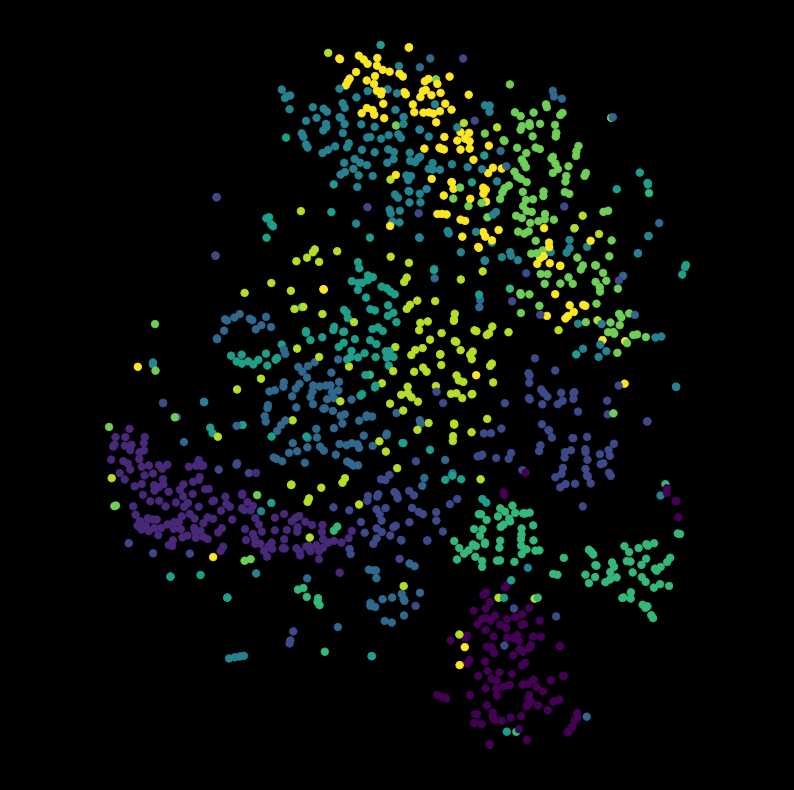

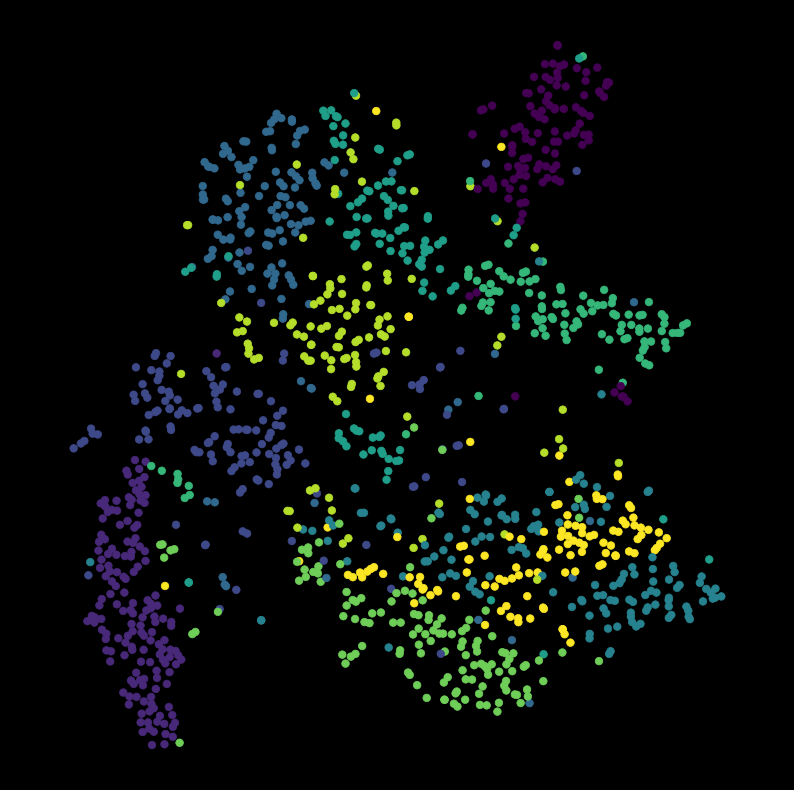

In [78]:
show_scatterplot(Ct_ae, Yt)
show_scatterplot(Ct_dae, Yt)

### Semi-supervised Classification

Get only 1000 labeled images for each class from MNIST training dataset (#training samples = 10k)

In [79]:
classes = torch.unique(train_data.targets)

nc = 500

data = []
targets = []
for cl in classes:
    idx = (train_data.targets == cl)
    X = train_data.data[idx]
    Y = train_data.targets[idx]
    print(f'[{cl}] {X.size()}')
    X = X[:nc]
    Y = Y[:nc]

    data.append(X)
    targets.append(Y)

data = torch.concatenate(data, axis=0)
targets = torch.concatenate(targets, axis=0)
print(f'data size: {tuple(data.size())}')
print(f'targets size: {tuple(targets.size())}')

# Get test data
data_test = test_data.data
targets_test = test_data.targets


[0] torch.Size([5923, 28, 28])
[1] torch.Size([6742, 28, 28])
[2] torch.Size([5958, 28, 28])
[3] torch.Size([6131, 28, 28])
[4] torch.Size([5842, 28, 28])
[5] torch.Size([5421, 28, 28])
[6] torch.Size([5918, 28, 28])
[7] torch.Size([6265, 28, 28])
[8] torch.Size([5851, 28, 28])
[9] torch.Size([5949, 28, 28])
data size: (5000, 28, 28)
targets size: (5000,)


In [80]:
# Transform images
data_transform = []
for idx in range(len(data)):
    img = Image.fromarray(data[idx].numpy(), mode="L")
    x = img_transform(img)
    data_transform.append(x)

data_transform = torch.concatenate(data_transform, axis=0)


data_transform_test = []
for idx in range(len(data_test)):
    img = Image.fromarray(data_test[idx].numpy(), mode="L")
    x = img_transform(img)
    data_transform_test.append(x)

data_transform_test = torch.concatenate(data_transform_test, axis=0)

Train Logistic Regression on Raw Data

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
clf = LogisticRegression(random_state=0)

In [83]:
# Train classifier
X = data_transform.view(-1, input_size).numpy()
y = targets.numpy()
clf.fit(X, y)

# Predict test data
Xt = data_transform_test.view(-1, input_size).numpy()
yt = targets_test.numpy()

y_pred = clf.predict(Xt)

/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Logistic Regression on AE and DAE

In [84]:
# Get training and test codes
with torch.no_grad():
    Z_ae = model_ae.encoder(data_transform.view(-1, input_size).to(DEVICE))
    Z_dae = model_dae.encoder(data_transform.view(-1, input_size).to(DEVICE))

    Z_ae_test = model_ae.encoder(data_transform_test.view(-1, input_size).to(DEVICE))
    Z_dae_test = model_dae.encoder(data_transform_test.view(-1, input_size).to(DEVICE))

print(f'Z_ae size: {tuple(Z_ae.size())}')
print(f'Z_dae size: {tuple(Z_dae.size())}')
print(f'Z_ae_test size: {tuple(Z_ae_test.size())}')
print(f'Z_dae_test size: {tuple(Z_dae_test.size())}')

Z_ae size: (5000, 128)
Z_dae size: (5000, 128)
Z_ae_test size: (10000, 128)
Z_dae_test size: (10000, 128)


In [85]:
# Train classifier on AE codes
clf.fit(Z_ae.numpy(), targets)

# Predict test data
y_pred_ae = clf.predict(Z_ae_test)

/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
# Train classifier on DAE codes
clf.fit(Z_dae.numpy(), targets)

# Predict test data
y_pred_dae = clf.predict(Z_dae_test)

/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
# Compute accuracy
num_correct = np.sum(yt == y_pred)
acc = num_correct * 100. / len(yt)

num_correct_ae = np.sum(yt == y_pred_ae)
acc_ae = num_correct_ae * 100. / len(yt)

num_correct_dae = np.sum(yt == y_pred_dae)
acc_dae = num_correct_dae * 100. / len(yt)

print(f' == Semi-Supervised Classification Performance ==\n')
print(f'[Raw] Accuracy: {acc:.2f}% [{num_correct} / {len(yt)}]]')
print(f'[AE] Accuracy: {acc_ae:.2f}% [{num_correct_ae} / {len(yt)}]]]')
print(f'[DAE] Accuracy: {acc_dae:.2f}% [{num_correct_dae} / {len(yt)}]]')

 == Semi-Supervised Classification Performance ==

[Raw] Accuracy: 88.52% [8852 / 10000]]
[AE] Accuracy: 89.46% [8946 / 10000]]]
[DAE] Accuracy: 90.59% [9059 / 10000]]
